# Network Mapping with RAPIDS and CLX

## Authors
 - Eli Fajardo (NVIDIA) [efajardo@nvidia.com]
 - Bartley Richardson (NVIDIA) [brichardson@nvidia.com]

## Development Notes
* Developed using: RAPIDS v0.11.0 and CLX v0.11
* Last tested using: RAPIDS v0.11.0 and CLX v0.11 on Nov 5, 2019

## Table of Contents
* Generate Network Map
* CLX Port Heuristic
* cuGraph PageRank and Louvain
* Visualization example
* Conclusion

## Introduction

In this notebook, we show an example of how to create a network map from [Zeek](https://www.zeek.org) ([formerly known as Bro](https://blog.zeek.org/2018/10/renaming-bro-project_11.html)) log data. We then enrich the nodes in our graph using a [CLX](https://github.com/rapidsai/clx) port heuristic analytic and [cuGraph Pagerank](https://docs.rapids.ai/api/cugraph/0.10/api.html#module-cugraph.link_analysis.pagerank). The data we use is a sample from the [UNSW-NB15 dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) which can be downloaded [here](https://cloudstor.aarnet.edu.au/plus/index.php/s/2DhnLGDdEECo4ys).

## Generate Network Map

In [1]:
import cudf
import cugraph
from cugraph.utilities.utils import is_device_version_less_than

from clx.heuristics import ports
import clx.parsers.zeek as zeek
import clx.ip

import pandas as pd
from os import path
import s3fs

### Download sample UNSW-NB15 Zeek conn.log

In [2]:
S3_BASE_PATH = "rapidsai-data/cyber/clx"
CONN_LOG = "conn.log"

# Download Zeek conn log
if not path.exists(CONN_LOG):
    fs = s3fs.S3FileSystem(anon=True)
    fs.get(S3_BASE_PATH + "/" + CONN_LOG, CONN_LOG)

### Build network mapping edge list using CLX to parse Zeek log file

In [3]:
# Defines how to build edges from Zeek log file
edge_defs = [
  {
    "dataSource": "unsw-mb15",
    "logPath": "conn.log",
    "edges": [
      {
        "srcCol": "id.orig_h",
        "srcPortCol": "id.orig_p",
        "srcNodeType": "address",
        "dstCol": "id.resp_h",
        "dstPortCol": "id.resp_p",
        "dstNodeType": "address",
        "timeCol": "ts",
        "relationship": "connect"
      }
    ]
  }
]

In [4]:
# Build edges cudf dataframe
edges_gdf = None

for log in edge_defs:

    # Use CLX Zeek parser here
    log_gdf = zeek.parse_log_file(log["logPath"])
    
    for e in log["edges"]:
        
        eventsDF = log_gdf
        
        if 'filters' in e:
            for f in e['filters']:
                eventsDF = eventsDF.query(f)
                        
        evt_edges_gdf = cudf.DataFrame()
        evt_edges_gdf['src'] = eventsDF[e["srcCol"]]
        evt_edges_gdf['dst'] = eventsDF[e["dstCol"]]
        evt_edges_gdf['src_port'] = eventsDF[e["srcPortCol"]]
        evt_edges_gdf['dst_port'] = eventsDF[e["dstPortCol"]]
        evt_edges_gdf['time'] = eventsDF[e["timeCol"]]
        evt_edges_gdf['src_node_type'] = e["srcNodeType"]
        evt_edges_gdf['dst_node_type'] = e["dstNodeType"]
        evt_edges_gdf['relationship'] = e["relationship"]
        evt_edges_gdf['data_source'] = log["dataSource"]
        
        if edges_gdf is None:
            edges_gdf = evt_edges_gdf
        else:
            edges_gdf = cudf.concat([edges_gdf, evt_edges_gdf])

## CLX Port Heuristic
We use a CLX port heuristic to find the major ports for each source and destination address. The heuristic also returns the IANA service name corresponding to each port number. Using the results of the heuristic, we enrich the address nodes in our network map with the top five source and destination ports and services.

In [5]:
src_ports = ports.major_ports(edges_gdf["src"], edges_gdf["src_port"])
dst_ports = ports.major_ports(edges_gdf["dst"], edges_gdf["dst_port"])

### Calculate top five ports for each source and destination address

In [6]:
def top_n(df, n=5):
    sorted_df = df.nlargest(n, "conns").sort_values(by="conns", ascending=False)
    return pd.Series([list(sorted_df["port"]), list(sorted_df["service"]), list(sorted_df["conns"])], ["ports","services","conns"])

In [7]:
src_ports_pd = src_ports.to_pandas()
src_ports_pd = src_ports_pd.groupby("addr").apply(top_n).reset_index()
src_ports_pd = src_ports_pd.rename(columns={"ports":"src_ports", "services":"src_services", "conns":"src_conns"})

In [8]:
dst_ports_pd = dst_ports.to_pandas()
dst_ports_pd = dst_ports_pd.groupby("addr").apply(top_n).reset_index()
dst_ports_pd = dst_ports_pd.rename(columns={"ports":"dst_ports", "services":"dst_services", "conns":"dst_conns"})

### Create single node list

In [9]:
nodes_pd = src_ports_pd.merge(dst_ports_pd, on=['addr'], how='outer')

## cuGraph PageRank and Louvain Modularity
Enrich nodes with cuGraph PageRank score and Louvain partition. Depending on the specifics of your network environment, you may want to pre-weight your PageRank algorithm (i.e., use Personalized PageRank), and you also may not care about community detection. We present both here as an example.

### Use CLX to convert IP addresses to integers

In [10]:
nodes_cg_pd = nodes_pd[["addr"]].drop_duplicates()
nodes_cg_gdf = cudf.from_pandas(nodes_cg_pd)
nodes_cg_gdf['idx'] = clx.ip.ip_to_int(nodes_cg_gdf['addr'])

### Build cuGraph graph

In [11]:
cg_edges_gdf = cudf.DataFrame()
cg_edges_gdf['src'] = clx.ip.ip_to_int(edges_gdf['src'])
cg_edges_gdf['dst'] = clx.ip.ip_to_int(edges_gdf['dst'])
cg_edges_gdf["data"] = 1.0

In [12]:
# create a Graph 
G = cugraph.Graph()
G.from_cudf_edgelist(cg_edges_gdf, source="src", destination="dst", renumber=True)

### Run cuGraph PageRank

In [13]:
pr_gdf = cugraph.pagerank(G, alpha=0.85, max_iter=500, tol=1.0e-05)
pr_gdf['idx'] = pr_gdf['vertex']
nodes_cg_gdf = nodes_cg_gdf.merge(pr_gdf, on=['idx'], how='left')
nodes_cg_gdf = nodes_cg_gdf.drop(['vertex'], axis=1)

### Run cuGraph Louvain

In [14]:
# only run lovain if running on newer than Pascal architecture
if not is_device_version_less_than((7, 0)):
    # Build new graph with edge values required for Louvain
    G = cugraph.Graph()
    G.from_cudf_edgelist(cg_edges_gdf, source="src", destination="dst", edge_attr='data', renumber=True)

    lv_gdf, lv_mod = cugraph.louvain(G) 
    part_ids = lv_gdf["partition"].unique()
    lv_gdf['idx'] = lv_gdf['vertex']
    nodes_cg_gdf = nodes_cg_gdf.merge(lv_gdf, on=['idx'], how='left')
    nodes_cg_gdf = nodes_cg_gdf.drop(['vertex'], axis=1)

    print(lv_mod) # Louvain modularity score

-0.031225887345679007


### Merge cuGraph results with original nodes dataframe

In [15]:
nodes_cg_pd = nodes_cg_gdf.drop(["idx"], axis=1).to_pandas()
nodes_pd = nodes_pd.merge(nodes_cg_pd, on=['addr'], how='left')

In [16]:
nodes_pd.head()

,addr,src_ports,src_services,src_conns,dst_ports,dst_services,dst_conns,pagerank,partition
0,10.40.182.6,[138],[netbios-dgm],[3],NaN,NaN,NaN,0.025000,15
1,10.40.85.1,[11],[systat],[1],NaN,NaN,NaN,0.007610,20
2,10.40.85.10,[8],[None],[14],NaN,NaN,NaN,0.036486,14
3,149.171.126.14,[179],[bgp],[1],"[445, 514, 80, 1723, 111]","[microsoft-ds, shell, http, pptp, sunrpc]","[116, 83, 70, 31, 26]",0.018699,18
4,149.171.126.15,[2048],[dls-monitor],[1],"[80, 445, 111, 179, 25]","[http, microsoft-ds, sunrpc, bgp, smtp]","[204, 60, 34, 27, 13]",0.018699,19


## Downstream Analytics / Viz

At this point, it's up to the user how they wish to proceed. Some will choose to take the enriched information back to another system (e.g., their SIEM). Others will want a visualization. Visualization can be accomplished a number of different ways, including using traditional PyDataViz techniques (e.g., Datashader), NetworkX visualizations, or a GPU-accelerated visualization tool like [Graphistry](https://www.graphistry.com). The ability to seamlessly transition between GPU-accelerated techniques and CPU-based techniques that may already be running is one of the benefits of RAPIDS. Below is a screenshot of this data visualized with Graphistry.

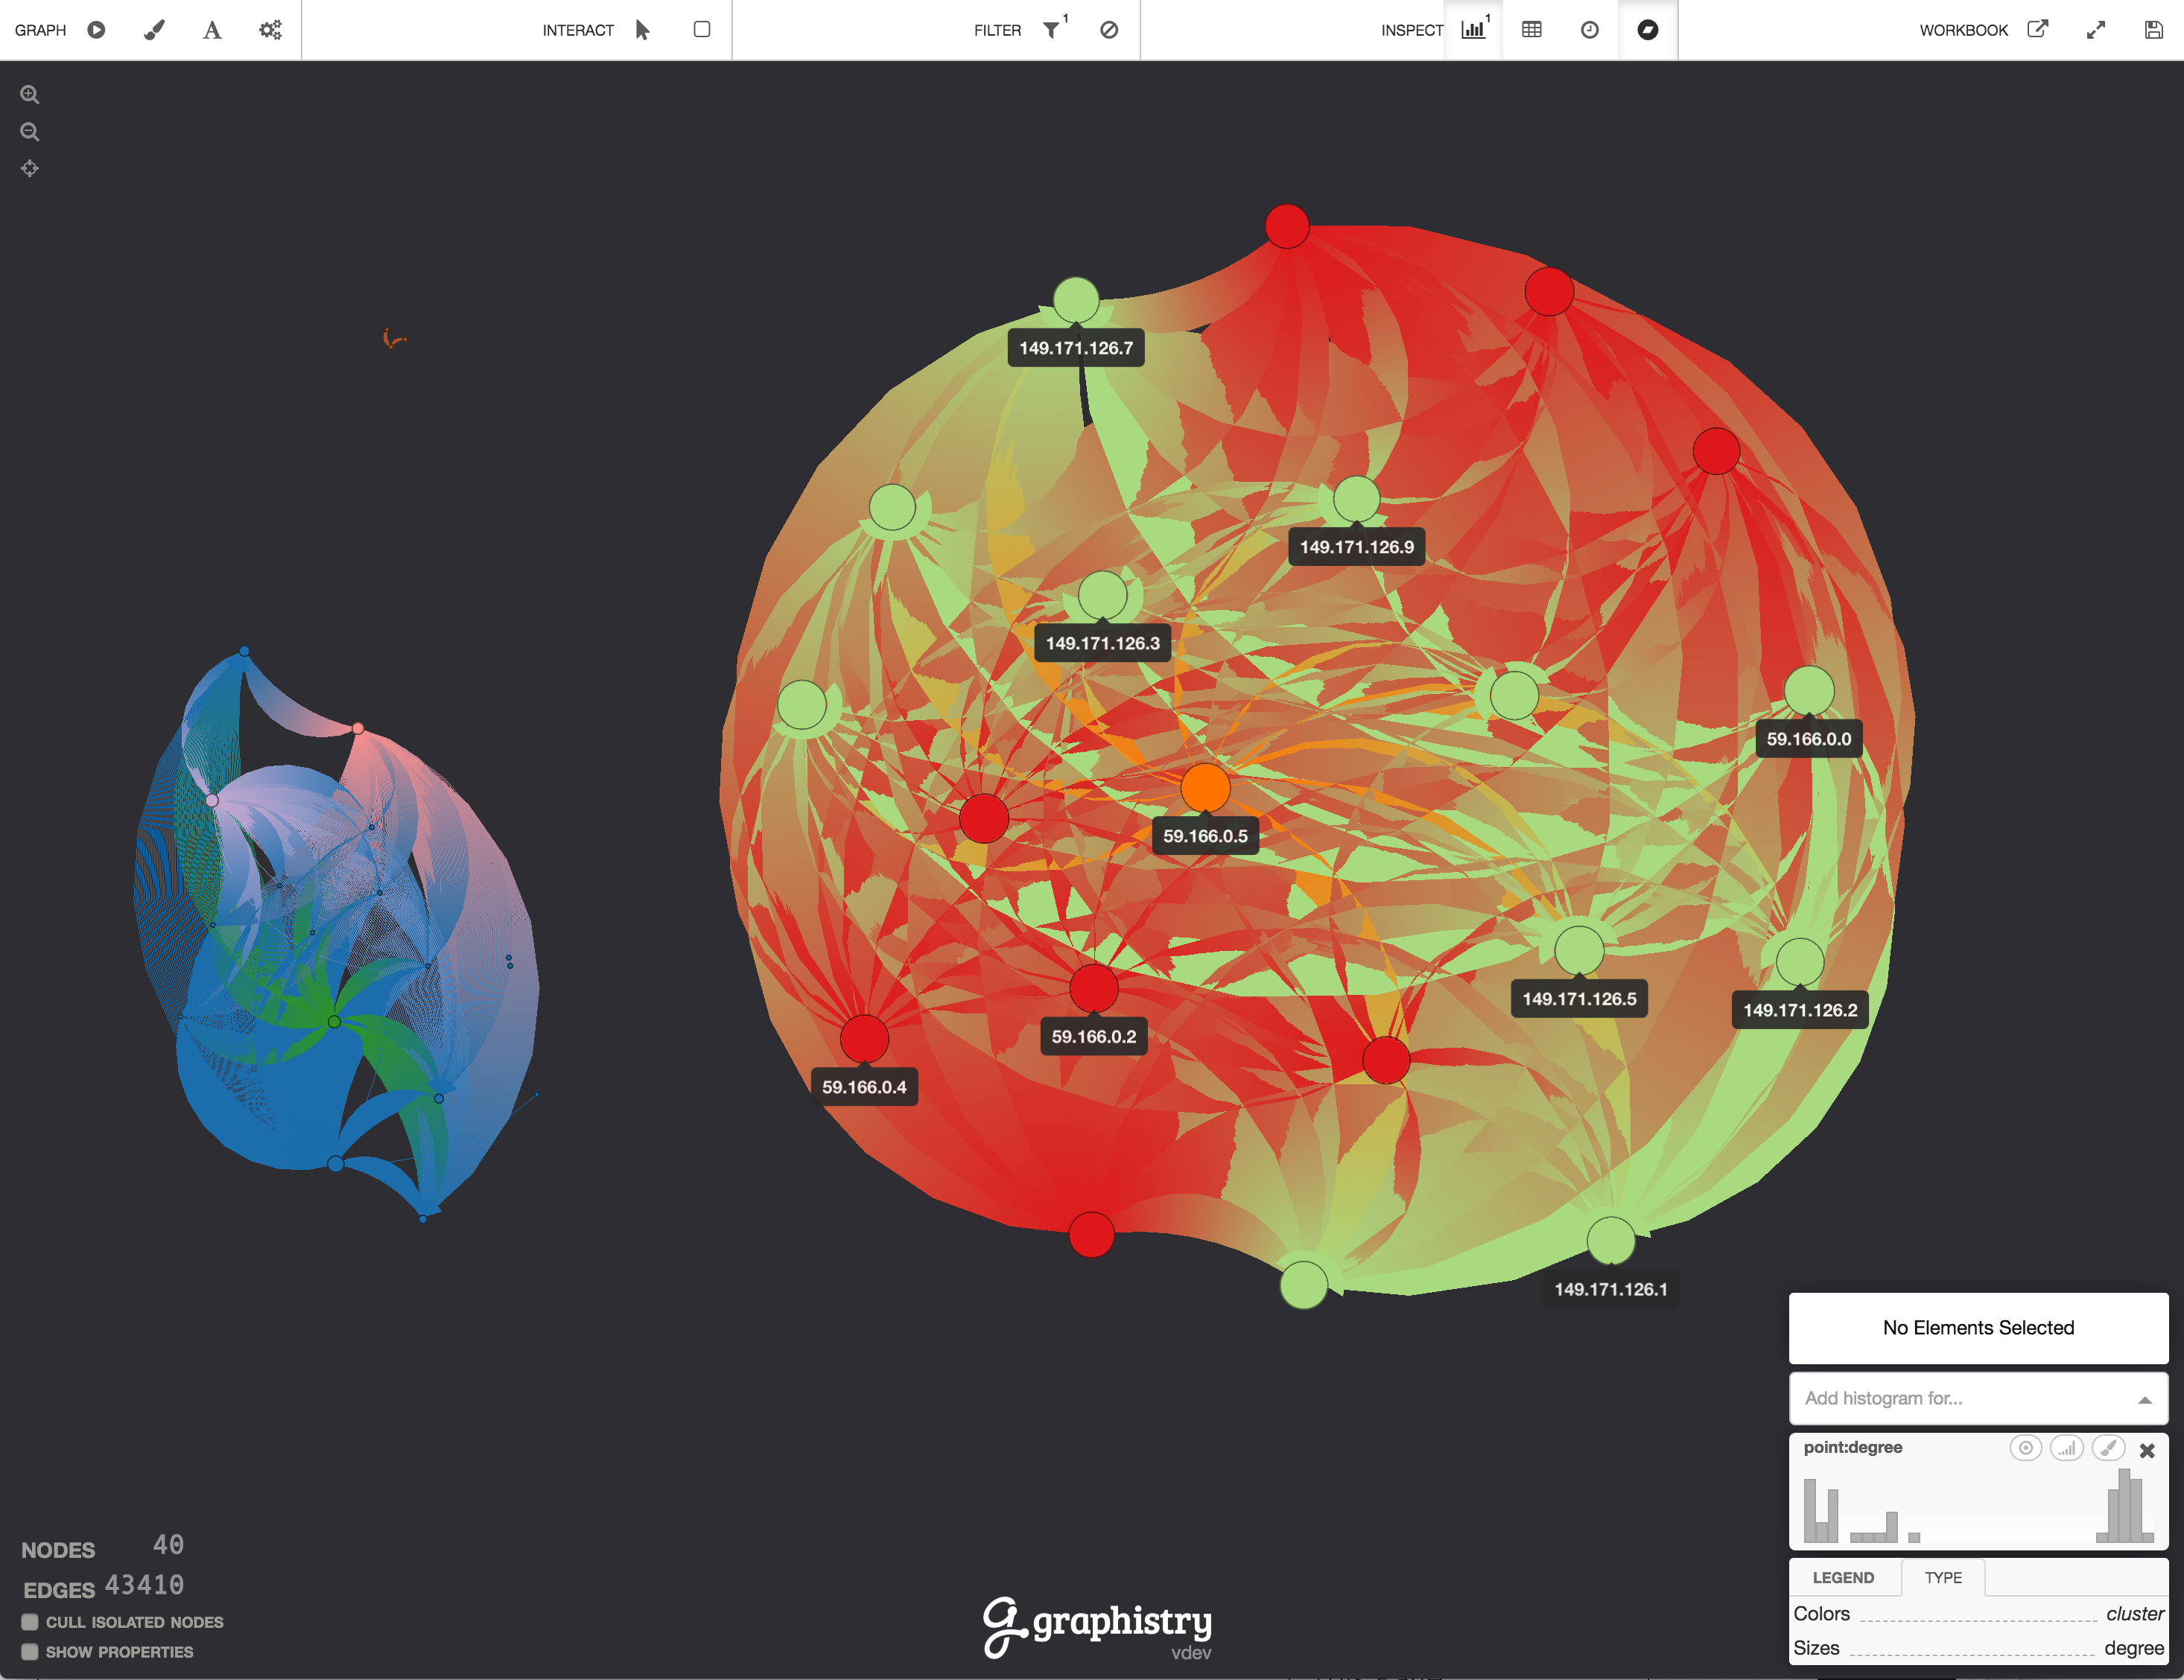

## Conclusion

In this notebook, we've shown how it's easy to use RAPIDS modules and CLX to quickly create a network map and enrich that map with analytic results while keeping data on the GPU. Speed is important for production, and the ability to run graph analytics like Pagerank quickly and consistently allows us to continuously update this network map and build alerting in near real time. Future additions to this work are slated to include subgraph matching/extraction as well as continuing to build out statistics based on connection behavior.